# YouTube Dataset
#### Черников Александр Алексеевич РИ-230910

## Часть 1. Подготовка к работе
#### Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

#### Читаем csv файл

In [2]:
df = pd.read_csv('/kaggle/input/youtube-ru/YouTube_RU.csv', delimiter=',', encoding='utf-8')
rows, columns = df.shape
display(df.head(5))
print(f'Количество строк: {rows} \nКоличество колонок: {columns}')

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,gDuslQ9avLc,17.14.11,Захар и Полина учатся экономить,Т—Ж БОГАЧ,22,2017-11-13T09:09:31.000Z,"захар и полина|""учимся экономить""|""копить день...",62408,334,190,50,https://i.ytimg.com/vi/gDuslQ9avLc/default.jpg,False,False,False,"Знакомьтесь, это Захар и Полина. Вместе с ними..."
1,AOCJIFEA_jE,17.14.11,Биржа Мемов #29. Большой выпуск,Druzhko Show,22,2017-11-13T17:32:11.000Z,"биржа мемов|""лев шагинян""|""мемы""|""пикчи""|""друж...",330043,43841,2244,2977,https://i.ytimg.com/vi/AOCJIFEA_jE/default.jpg,False,False,False,"В 29 выпуске Дружко Шоу Сергей сказал, что Бир..."
2,VAWNQDgwwOM,17.14.11,ХАЙП КЭМП - СВОЙ СРЕДИ ЧУЖИХ,Юлик,24,2017-11-13T16:11:31.000Z,"юмор|""комедия""|""влог""|""блог""|""смешно""|""смешное...",424596,49854,714,2944,https://i.ytimg.com/vi/VAWNQDgwwOM/default.jpg,False,False,False,http://kapitany.ru/!Yulik.cap - Факультет #Кап...
3,gknkFwKQfHg,17.14.11,Сочная кесадилья с курицей,Hochland,22,2017-11-13T06:51:10.000Z,"хохланд|""сыр""|""рецепты""|""как приготовить""|""вку...",112851,3566,122,80,https://i.ytimg.com/vi/gknkFwKQfHg/default.jpg,False,False,False,*** как готовить ресторанные блюда дома
4,3sYvZcwzZr8,17.14.11,КЛИПЫ РОДИТЕЛЕЙ НА ШКОЛЬНЫЙ ВЫПУСКНОЙ,Совергон,24,2017-11-13T16:52:36.000Z,"Совергон|""Sovergon""|""клипы""|""родители""|""школа""...",243469,36216,631,1692,https://i.ytimg.com/vi/3sYvZcwzZr8/default.jpg,False,False,False,❏ КОНКУРС КАПИТАНЫ: http://kapitany.ru/!Soverg...


Количество строк: 40739 
Количество колонок: 16


Оригинальный датасет имел проблему с кодированием текста из-за чего пришлось устанавливать его и сохранять с правильной кодировкой.

Датасет имеет следующие колонки:

video_id - уникальный идентификатор видео.(строка)

trending_date - дата нахождения видео на вкладке "в тренде". Видео может несколько дней находится на вкладке.(дата)

title - заголовок видео.(строка)

channel_title - название канала.(строка)

category_id - уникальный идентификатор категории.(число)

publish_time - дата публикации видео.(дата)

tags - тэги видео.(строка)

views - количество просмотров.(число)

likes - количество лайков.(число)

dislikes - количество дизлайков.(число)

comment_count - количество комментариев.(число)

thumbnail_link - ссылка на обложку видео.(текст)

comments_disabled - отключены\включены комментарии.(bool)

ratings_disabled - отключен\включен рейтинг.(bool)

video_error_or_removed - ошибка или удаленно(bool)

description - описание видео.(строка)


Словарь с идентификаторами и названиями категорий встречающихся в датасете. Будет использован далее для наглядности анализа.

In [3]:
category_names = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    19: "Travel & Events",
    20: "Gaming",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    43: "Shows"
}

## Часть 2. EDA 

### Корреляция параметров
Проверим корреляцию начальных параметров датасета.

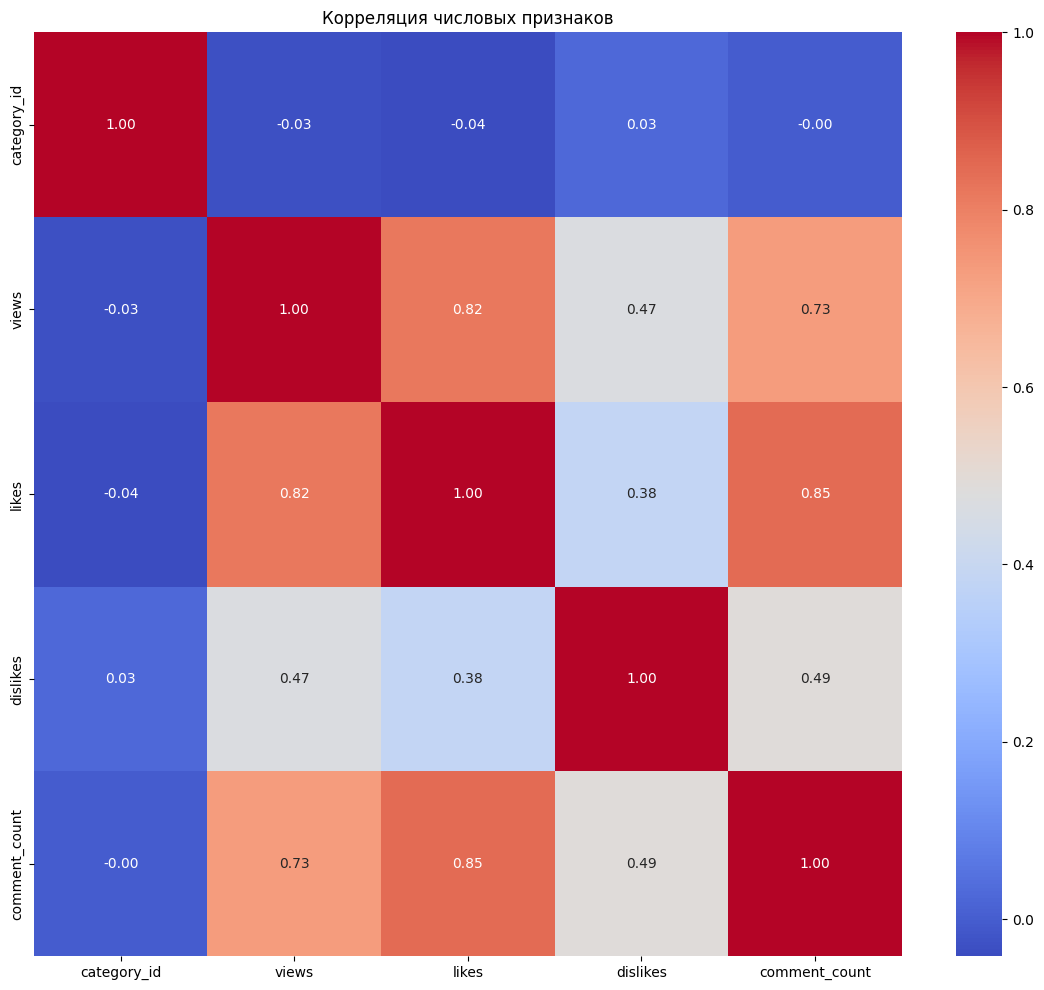

In [4]:
# Выбираем только числовые колонки для матрицы корреляции
numeric_df = df.select_dtypes(include=np.number)

# Строим тепловую карту
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция числовых признаков')
plt.show()

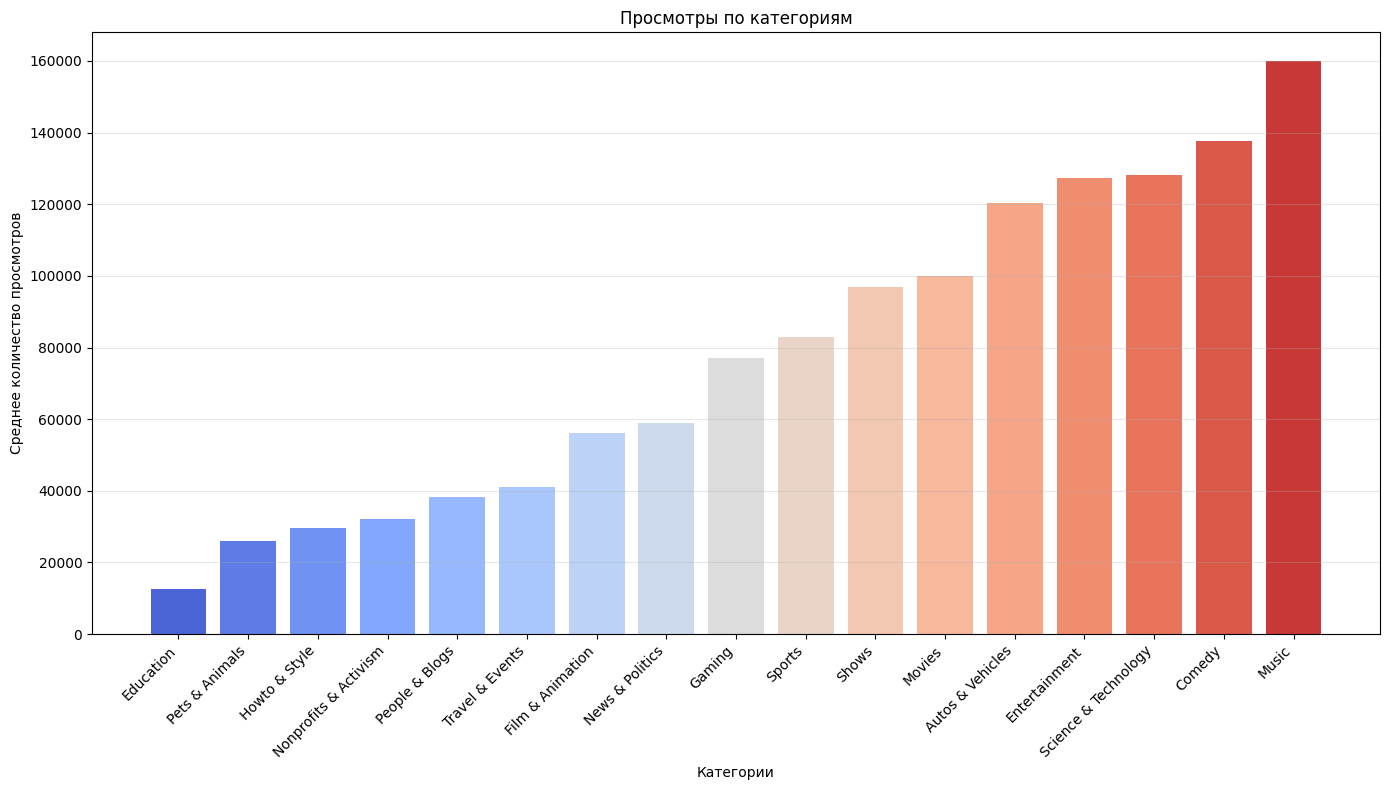

In [5]:
category_groups = df.groupby('category_id')['views'].median().reset_index()

category_groups['category_name'] = category_groups['category_id'].map(category_names)

category_groups_sorted = category_groups.sort_values('views', ascending=True)

plt.figure(figsize=(14, 8))
plt.bar(
    category_groups_sorted['category_name'],
    category_groups_sorted['views'],
    color=sns.color_palette('coolwarm', len(category_groups_sorted))
)
plt.xlabel('Категории')
plt.ylabel('Среднее количество просмотров')
plt.title('Просмотры по категориям')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

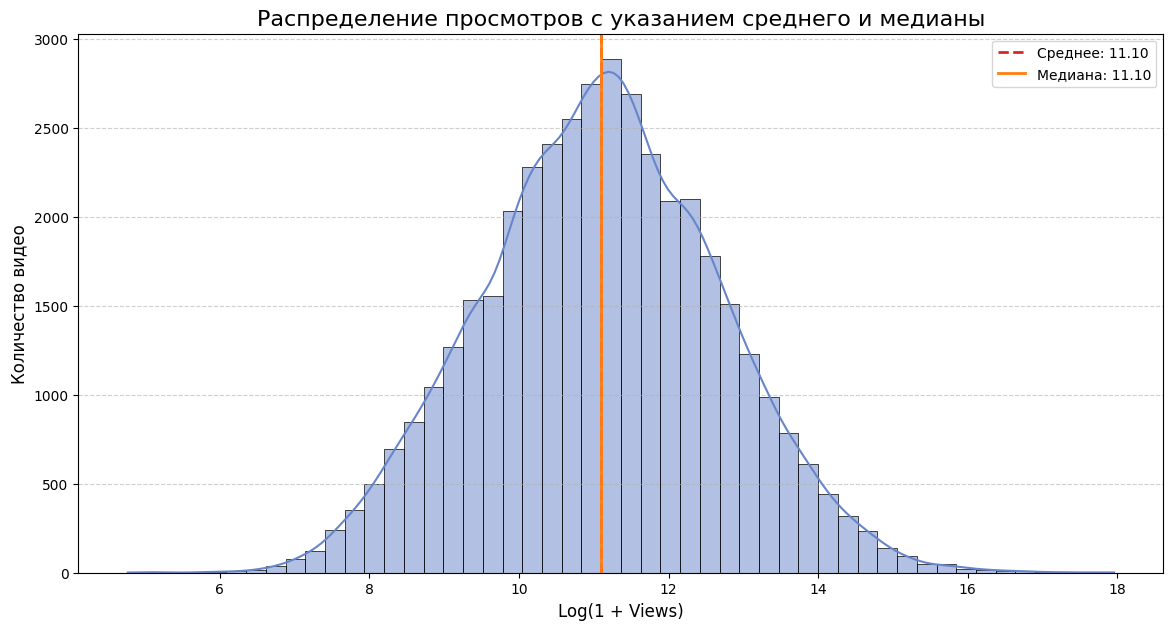

In [6]:
log_views = np.log1p(df['views'])
log_mean = log_views.mean()
log_median = log_views.median()

plt.figure(figsize=(14, 7))

sns.histplot(log_views, bins=50, kde=True, color='#6785c9', edgecolor='black', linewidth=0.5)

# Добавляем вертикальные линии
plt.axvline(log_mean, color='#d62728', linestyle='--', linewidth=2, label=f'Среднее: {log_mean:.2f}')
plt.axvline(log_median, color='#ff7f0e', linestyle='-', linewidth=2, label=f'Медиана: {log_median:.2f}')

plt.title('Распределение просмотров с указанием среднего и медианы', fontsize=16)
plt.xlabel('Log(1 + Views)', fontsize=12)
plt.ylabel('Количество видео', fontsize=12)
plt.legend() # Отображаем легенду с подписями линий
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

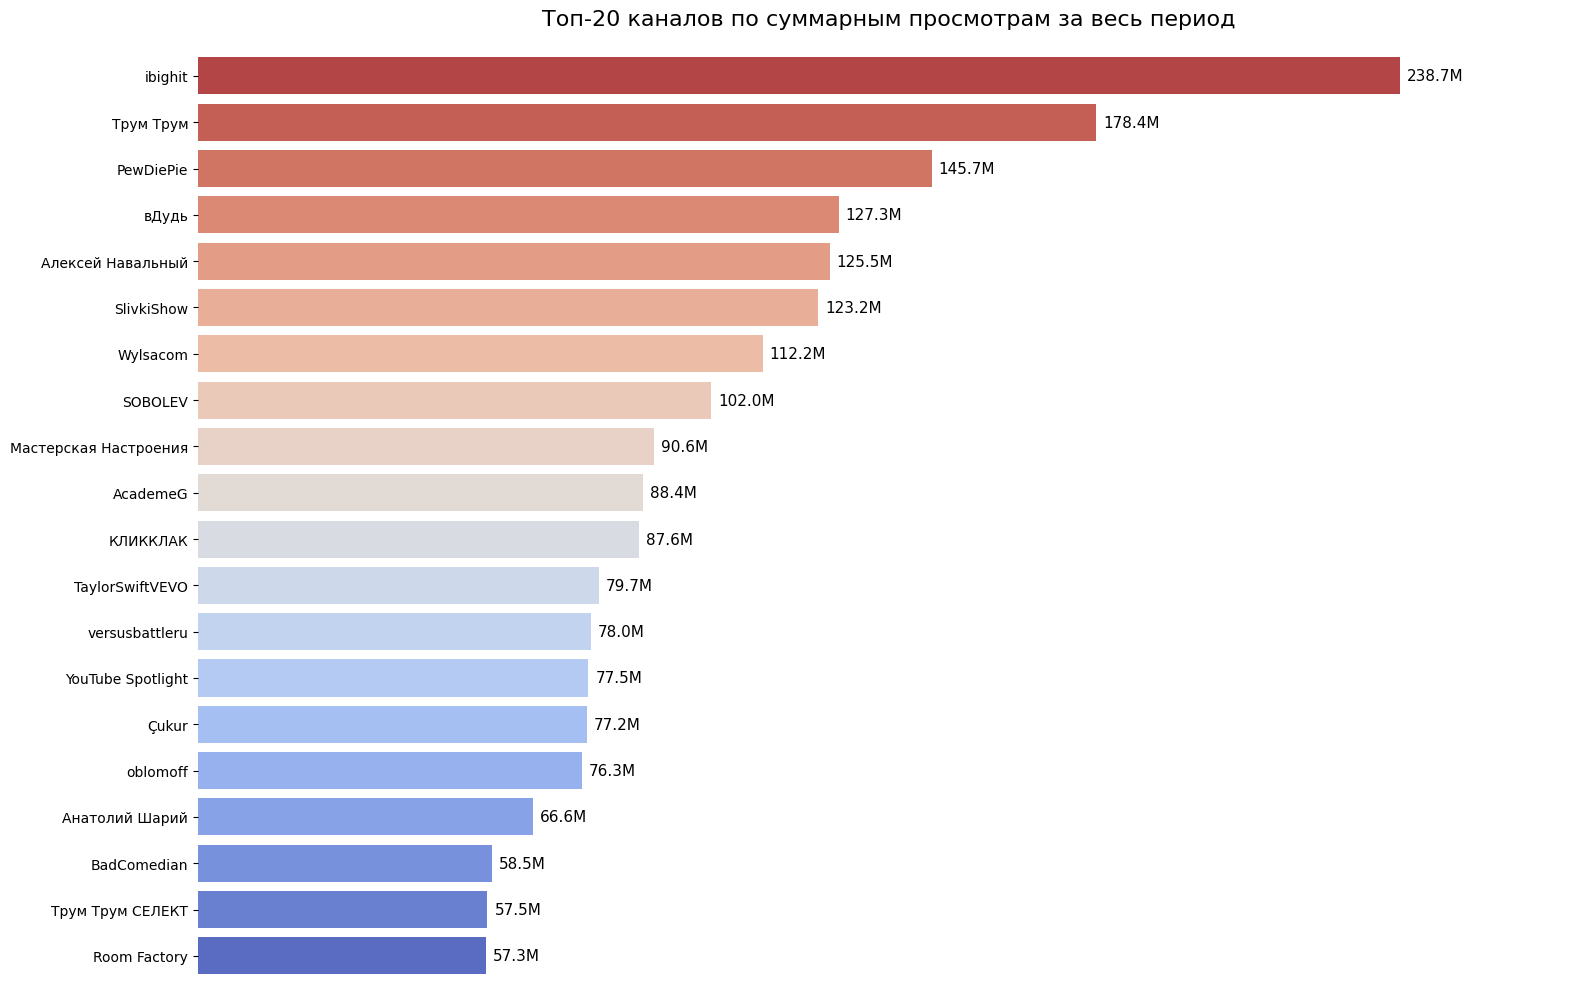

In [7]:
top_channels = df.groupby('channel_title')['views'].sum().nlargest(20)

plt.figure(figsize=(16, 10))

ax = sns.barplot(
    x=top_channels.values,
    y=top_channels.index,
    palette='coolwarm_r',
    orient='h'
)

labels = [f'{val/1e6:.1f}M' for val in top_channels.values]
ax.bar_label(ax.containers[0], labels=labels, padding=5, fontsize=11, color='black')

sns.despine(left=True, bottom=True)

ax.set_title('Топ-20 каналов по суммарным просмотрам за весь период', fontsize=16, pad=20)
ax.set_xlabel('Суммарные просмотры', fontsize=12)
ax.set_ylabel('')

ax.set_xlim(right=top_channels.values.max() * 1.15)

ax.get_xaxis().set_visible(False)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

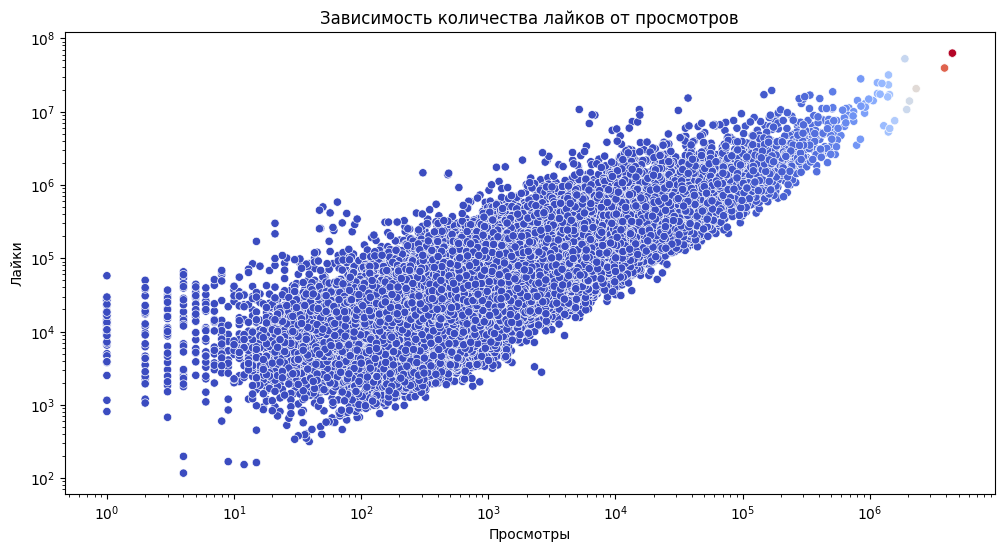

In [8]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x=df['likes'],
    y=df['views'],
    c=df['likes'], # Раскрасим точки по количеству лайков
    cmap='coolwarm',
)
plt.title('Зависимость количества лайков от просмотров')
plt.xlabel('Просмотры')
plt.ylabel('Лайки')
plt.xscale('log') # Используем логарифмическую шкалу для наглядности
plt.yscale('log')
plt.show()

## Часть 3. Feature Engineering

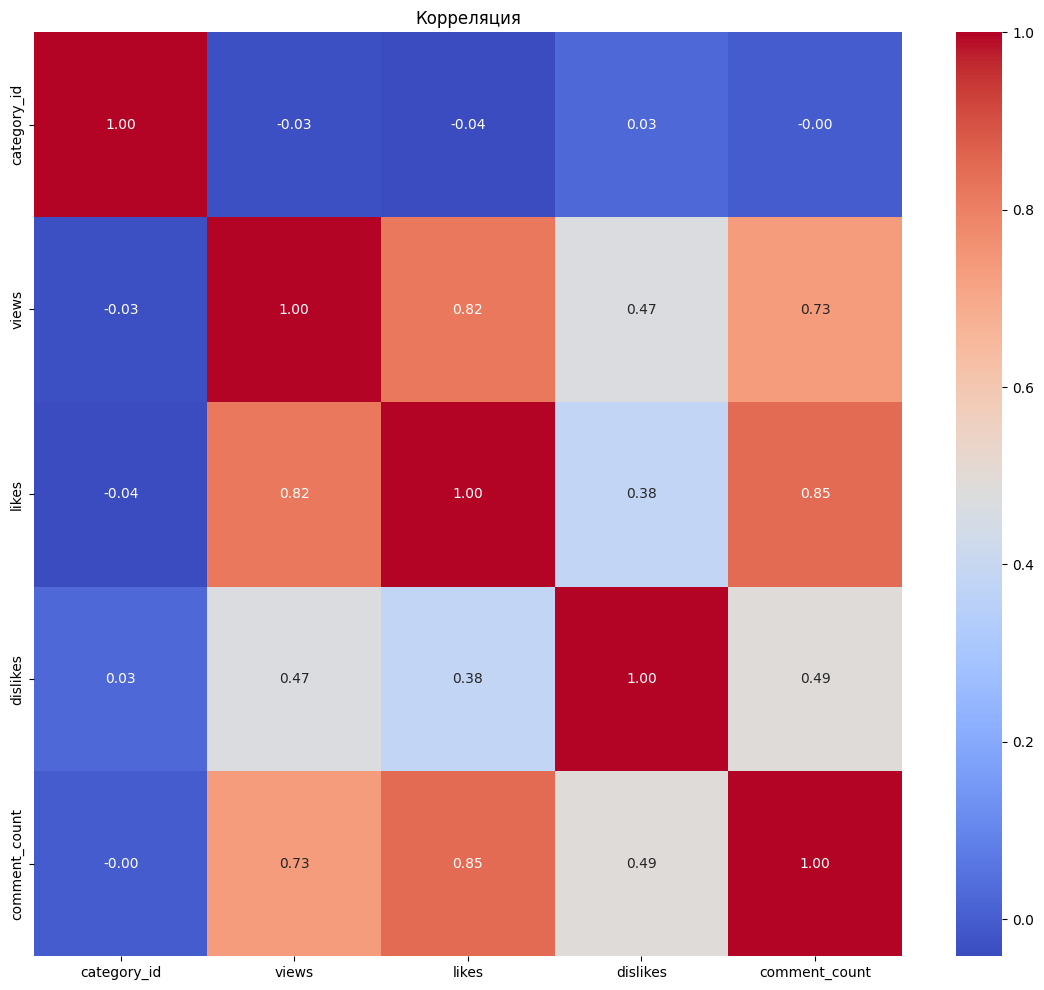

In [9]:
numeric_df = df.select_dtypes(include=np.number)

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция')
plt.show()

Переведем trending_date и publish_time в datetime формат, также вынесем час и день недели публикации в отдельные колонки для дальнейшего анализа

In [10]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

df['publish_hour'] = df['publish_time'].dt.hour
df['publish_dow'] = df['publish_time'].dt.dayofweek

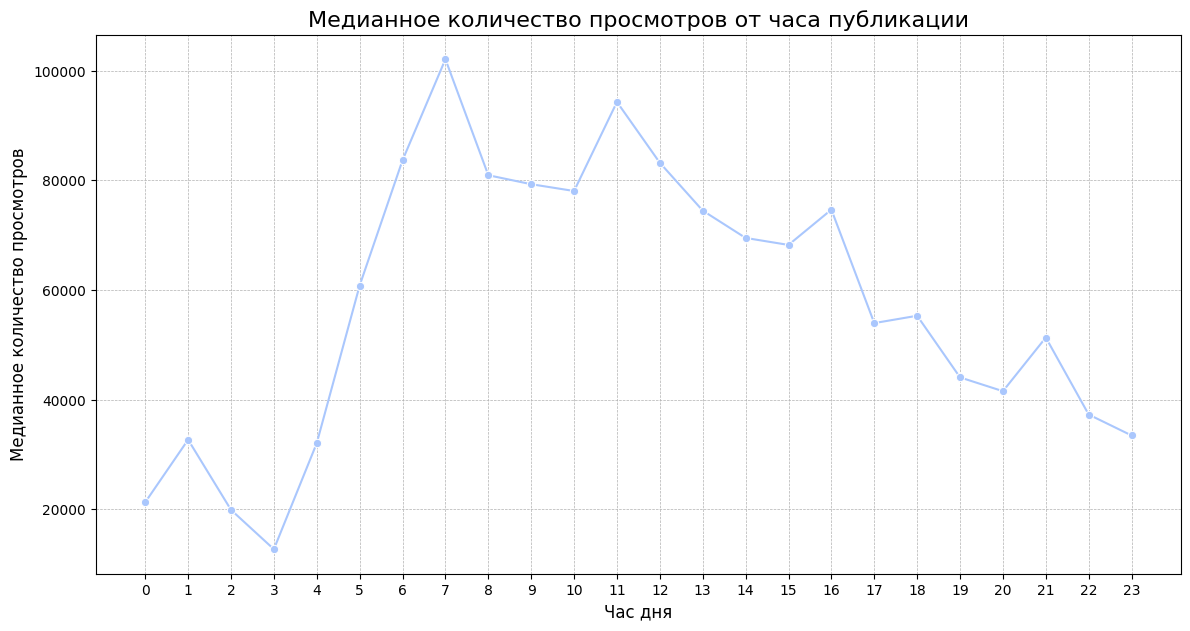

In [11]:
hour_groups = df.groupby('publish_hour')['views'].median()
plt.figure(figsize=(14, 7))
sns.lineplot(x=hour_groups.index, y=hour_groups.values, marker='o', color=sns.color_palette('coolwarm', 2)[0])
plt.title('Медианное количество просмотров от часа публикации', fontsize=16)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Медианное количество просмотров', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

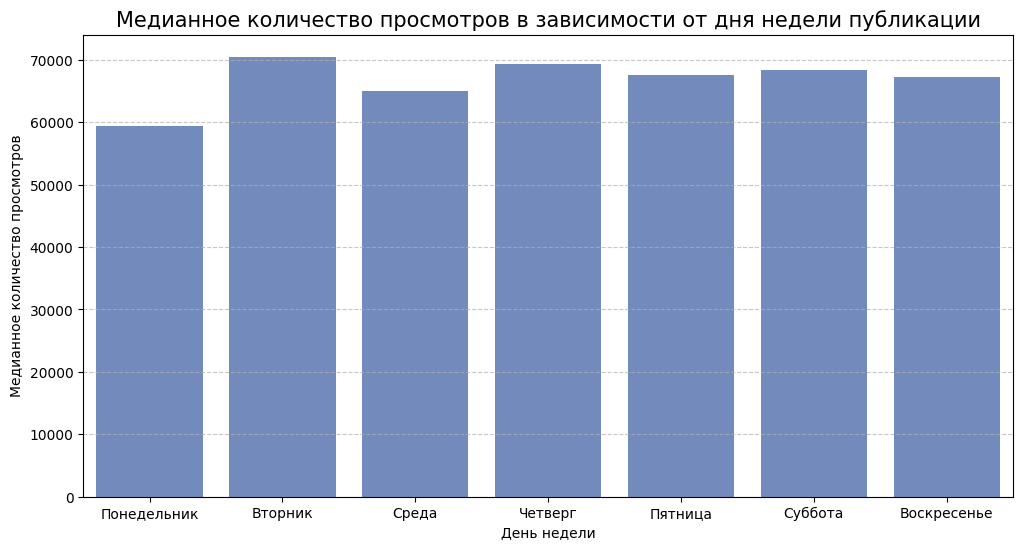

In [12]:
# Группируем по дню недели и считаем медиану просмотров
dow_groups = df.groupby('publish_dow')['views'].median().reset_index()

# Словарь для названий дней недели для красивых меток
day_names = {
    0: 'Понедельник', 1: 'Вторник', 2: 'Среда',
    3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'
}
dow_groups['day_name'] = dow_groups['publish_dow'].map(day_names)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=dow_groups,
    x='day_name',
    y='views',
    color='#6785c9'
)
plt.title('Медианное количество просмотров в зависимости от дня недели публикации', fontsize=15)
plt.xlabel('День недели')
plt.ylabel('Медианное количество просмотров')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Добавим колонки с длинной заголовка и количеством тегов. 

In [13]:
df['title_length'] = df['title'].apply(len)

df['tags'] = df['tags'].apply(lambda x: '' if str(x).strip().lower() == '[none]' else x)
df['tags_count'] = df['tags'].apply(lambda x: len(x.split('|')))

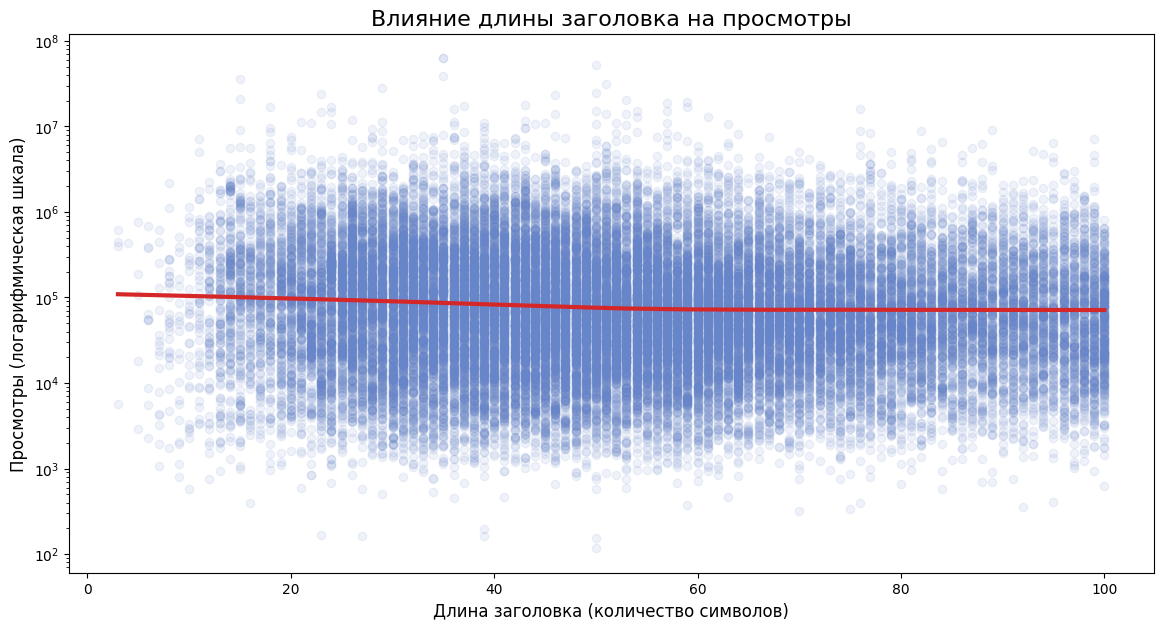

In [14]:
plt.figure(figsize=(14, 7))
sns.regplot(
    data=df, x='title_length', y='views',
    scatter_kws={'alpha': 0.1, 'color': '#6785c9'},
    line_kws={'color': '#d62728', 'linewidth': 3},
    lowess=True # Построение сглаженной трендовой линии
)
plt.yscale('log')
plt.title('Влияние длины заголовка на просмотры', fontsize=16)
plt.xlabel('Длина заголовка (количество символов)', fontsize=12)
plt.ylabel('Просмотры (логарифмическая шкала)', fontsize=12)
plt.show()

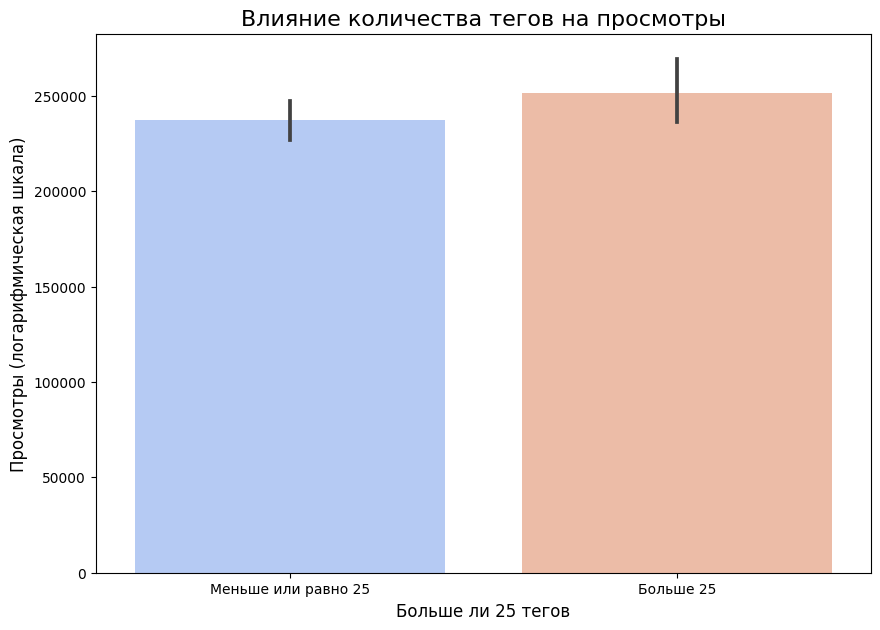

In [15]:
df['many_tags'] = df['tags_count'] > 25
plt.figure(figsize=(10, 7))
sns.barplot(data=df, x='many_tags', y='views', palette='coolwarm')
plt.title('Влияние количества тегов на просмотры', fontsize=16)
plt.xlabel('Больше ли 25 тегов', fontsize=12)
plt.ylabel('Просмотры (логарифмическая шкала)', fontsize=12)
plt.xticks([0, 1], ['Меньше или равно 25', 'Больше 25'])
plt.show()


Добавим колонки с суммой всех взаимодействий и соотношением лайков к дизлайкам

In [16]:
df['total_interactions'] = df['likes'] + df['comment_count'] + df['dislikes']
df['like_dislike_ratio'] = df['likes'] / (df['dislikes'] + 1)

Добавим колонки с количеством слов в описании и наличием ссылок, также добавим специальную колонку для выделения видео без описаний.

In [17]:
df['description_missing'] = df['description'].isnull()
df['description'] = df['description'].fillna('')
df['description_word_count'] = df['description'].apply(lambda x: len(x.split()))
df['has_links'] = df['description'].str.contains('http://|https://').astype(int)

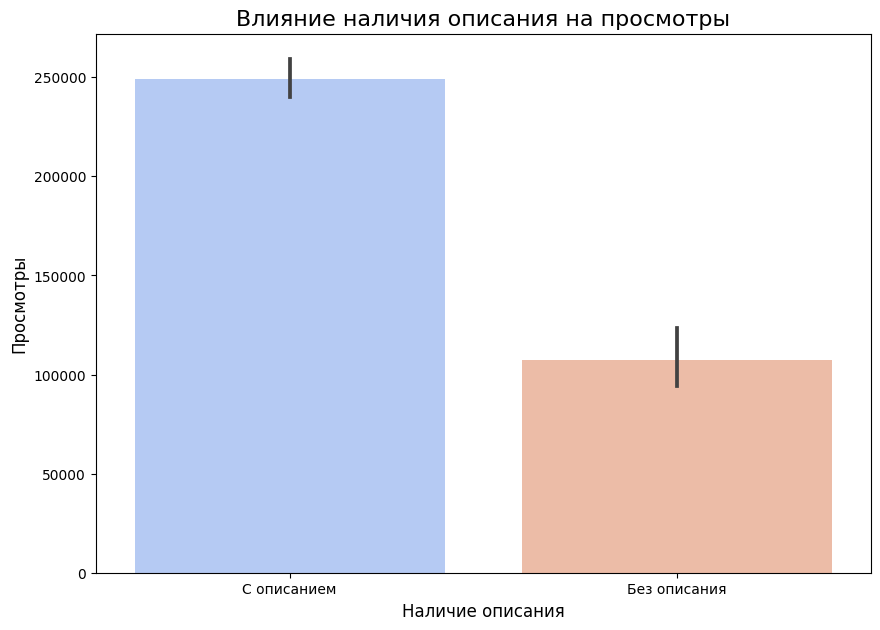

In [18]:
plt.figure(figsize=(10, 7))
sns.barplot(data=df, x='description_missing', y='views', palette='coolwarm')
plt.title('Влияние наличия описания на просмотры', fontsize=16)
plt.xlabel('Наличие описания', fontsize=12)
plt.ylabel('Просмотры', fontsize=12)
plt.xticks([False, True], ['С описанием', 'Без описания'])
plt.show()

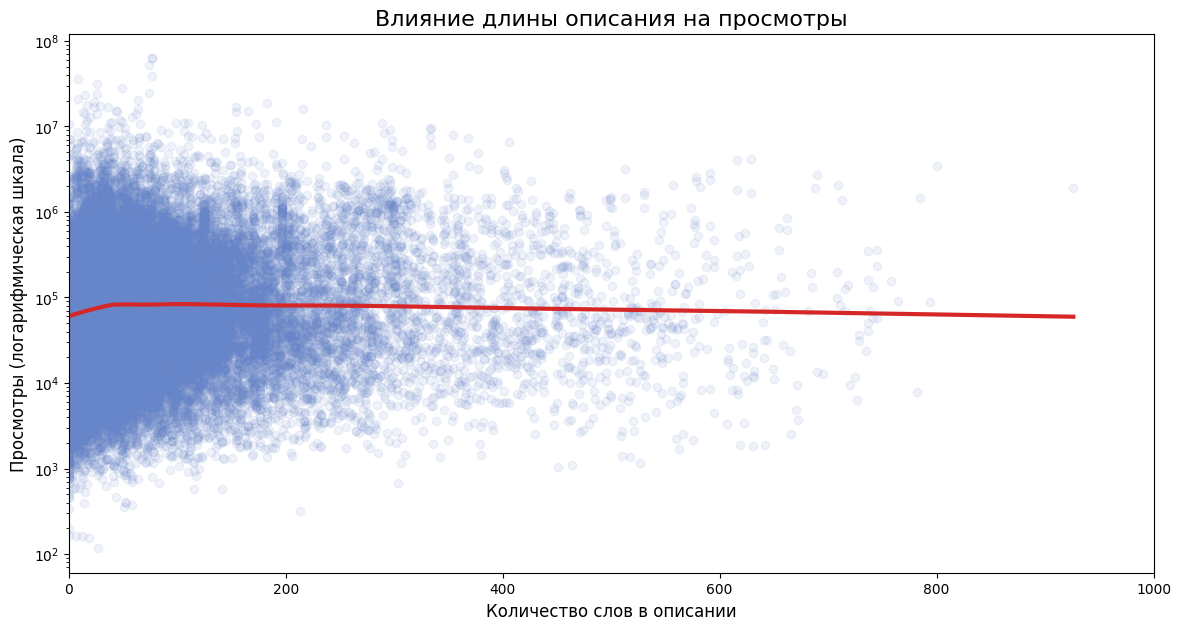

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,publish_hour,publish_dow,title_length,tags_count,many_tags,total_interactions,like_dislike_ratio,description_missing,description_word_count,has_links
0,gDuslQ9avLc,2017-11-14,Захар и Полина учатся экономить,Т—Ж БОГАЧ,22,2017-11-13 09:09:31+00:00,"захар и полина|""учимся экономить""|""копить день...",62408,334,190,...,9,0,31,14,False,574,1.748691,False,93,1
1,AOCJIFEA_jE,2017-11-14,Биржа Мемов #29. Большой выпуск,Druzhko Show,22,2017-11-13 17:32:11+00:00,"биржа мемов|""лев шагинян""|""мемы""|""пикчи""|""друж...",330043,43841,2244,...,17,0,32,16,False,49062,19.528285,False,80,1
2,VAWNQDgwwOM,2017-11-14,ХАЙП КЭМП - СВОЙ СРЕДИ ЧУЖИХ,Юлик,24,2017-11-13 16:11:31+00:00,"юмор|""комедия""|""влог""|""блог""|""смешно""|""смешное...",424596,49854,714,...,16,0,28,14,False,53512,69.725874,False,13,1
3,gknkFwKQfHg,2017-11-14,Сочная кесадилья с курицей,Hochland,22,2017-11-13 06:51:10+00:00,"хохланд|""сыр""|""рецепты""|""как приготовить""|""вку...",112851,3566,122,...,6,0,26,6,False,3768,28.991870,False,6,0
4,3sYvZcwzZr8,2017-11-14,КЛИПЫ РОДИТЕЛЕЙ НА ШКОЛЬНЫЙ ВЫПУСКНОЙ,Совергон,24,2017-11-13 16:52:36+00:00,"Совергон|""Sovergon""|""клипы""|""родители""|""школа""...",243469,36216,631,...,16,0,37,33,True,38539,57.303797,False,74,1


In [19]:
plt.figure(figsize=(14, 7))
sns.regplot(
    data=df, x='description_word_count', y='views',
    scatter_kws={'alpha': 0.1, 'color': '#6785c9'},
    line_kws={'color': '#d62728', 'linewidth': 3},
    lowess=True
)
plt.yscale('log')
plt.xlim(0, 1000) # Ограничим ось X для наглядности
plt.title('Влияние длины описания на просмотры', fontsize=16)
plt.xlabel('Количество слов в описании', fontsize=12)
plt.ylabel('Просмотры (логарифмическая шкала)', fontsize=12)
plt.show()

df.head(5)

# Часть 4. Модели

### Загрузка данных

In [20]:
data = pd.read_csv('/kaggle/input/youtube-ru/YouTube_RU.csv', delimiter=',', encoding='utf-8')

# Преобразование временных меток
data['publish_time'] = pd.to_datetime(data['publish_time'])
data['publish_hour'] = data['publish_time'].dt.hour
data['publish_dow'] = data['publish_time'].dt.dayofweek

# Текстовые признаки
data['title_length'] = data['title'].apply(len)
data['tags'] = data['tags'].apply(lambda x: '' if str(x).strip().lower() == '[none]' else x)
data['tags_count'] = data['tags'].apply(lambda x: len(x.split('|')))
data['description'] = data['description'].fillna('')
data['description_word_count'] = data['description'].apply(lambda x: len(x.split()))
data['has_links'] = data['description'].str.contains('http://|https://').astype(int)

# Удаление утекших признаков и ненужных столбцов
data = data.drop(columns=['likes', 'dislikes', 'comment_count', 'video_id', 'trending_date', 
                         'title', 'channel_title', 'publish_time', 'tags', 
                         'thumbnail_link', 'description'])

### Подготовка признаков и целевой переменной
Логарифмирование целевой переменной и разделение данных

In [21]:
y = np.log1p(data['views'])
X = data.drop(columns=['views'])

Определение типов признаков

In [22]:
numeric_features = [
    'publish_hour', 'title_length', 'tags_count', 
    'description_word_count','has_links'
]
categorical_features = ['category_id', 'publish_dow']

### Конвейер предобработки
Стандартизация числовых признаков и one-hot кодирование категориальных

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

### Определение моделей
Настройки для улучшенной производительности

In [24]:
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        random_state=42, 
        n_jobs=-1
    ),
    "LightGBM": lgb.LGBMRegressor(
        num_leaves=31,
        max_depth=8,
        learning_rate=0.05,
        n_estimators=300,
        random_state=42, 
        n_jobs=-1
    ),
    "MLP": MLPRegressor(
        hidden_layer_sizes=(128, 64), 
        activation='relu',
        solver='adam',
        max_iter=500, 
        random_state=42, 
        early_stopping=True
    )
}

### Кросс-валидация
Оценка производительности моделей с использованием 5 фолдов

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    rmse_scores = cross_val_score(pipeline, X, y, cv=kf, 
                                 scoring='neg_root_mean_squared_error', 
                                 n_jobs=-1)
    r2_scores = cross_val_score(pipeline, X, y, cv=kf, 
                               scoring='r2', 
                               n_jobs=-1)
    
    results[name] = {
        'RMSE_mean': -rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std()
    }
    print(f"{name} | RMSE: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f} | R²: {r2_scores.mean():.4f}")

Ridge | RMSE: 1.4726 ± 0.0121 | R²: 0.1395
Random Forest | RMSE: 1.2596 ± 0.0103 | R²: 0.3704
LightGBM | RMSE: 1.3115 ± 0.0116 | R²: 0.3175
MLP | RMSE: 1.3608 ± 0.0100 | R²: 0.2651


### Анализ результатов
Сравнение моделей и выбор лучшей


--- Результаты кросс-валидации ---


,RMSE_mean,RMSE_std,R2_mean,R2_std
Random Forest,1.259591,0.010290,0.370410,0.005085
LightGBM,1.311505,0.011642,0.317451,0.005721
MLP,1.360809,0.009980,0.265133,0.007700
Ridge,1.472558,0.012110,0.139505,0.008117


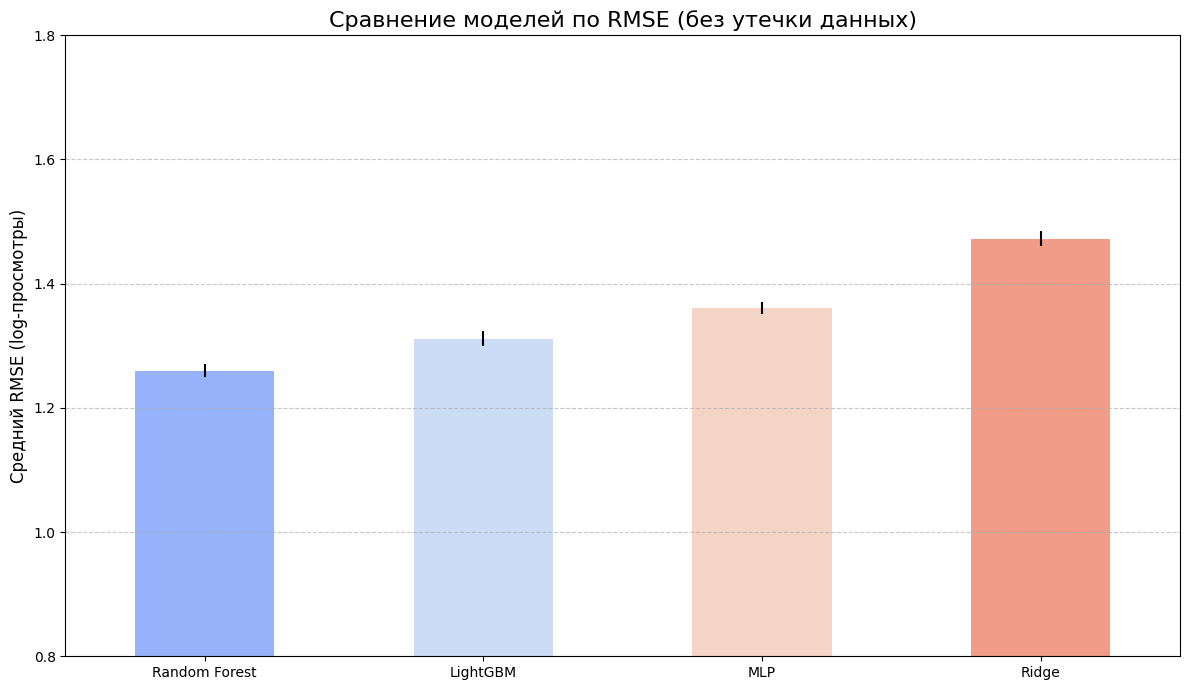

In [26]:
results_df = pd.DataFrame(results).T.sort_values(by='RMSE_mean', ascending=True)
print("\n--- Результаты кросс-валидации ---")
display(results_df)

# Визуализация
plt.figure(figsize=(12, 7))
results_df['RMSE_mean'].plot(kind='bar', yerr=results_df['RMSE_std'], 
                            color=sns.color_palette('coolwarm', 4), alpha=0.8)
plt.title('Сравнение моделей по RMSE (без утечки данных)', fontsize=16)
plt.ylabel('Средний RMSE (log-просмотры)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.8, 1.8)
plt.tight_layout()
plt.show()

### Выводы
**Лучшая модель:** Random Forest
**Средний RMSE:** 1.2596
**Объясненная дисперсия (R²):** 0.3704